# TCR Dist approx

The distance function takes a long time. In this, we search for a suitable approximation.


In [1]:
import numpy as np
import pandas as pd
from tcrdist.repertoire import TCRrep


def calculate_tcr_dist2(seq1, seq2, nan_distance=0):
    if (seq1 == seq2).all():
        return 0

    # create a dataframe with the two sequences

    # seq1 and seq2 are two rows in the tDataFrame
    # the columns are cdr3_a_aa, v_a_gene, j_a_gene, cdr3_b_aa, v_b_gene, j_b_gene

    df = pd.DataFrame([seq1, seq2], columns=['cdr3_a_aa', 'v_a_gene', 'j_a_gene', 'cdr3_b_aa', 'v_b_gene', 'j_b_gene'])
    df['count'] = 1

    # contains the df a nan value?
    if df.isnull().values.any():
        return nan_distance

    # create a TCRrep object
    tr = TCRrep(cell_df=df,
                organism='human',
                chains=['alpha', 'beta'],
                db_file='alphabeta_gammadelta_db.tsv'
                )
    # compute the distances
    tr.compute_distances()
    # get the computed distances
    # return tr.pw_cdr3_a_aa[0][1], tr.pw_cdr3_b_aa[0][1]
    # if pw_alpha is 1x1, return it's only value (probably 0) # todo: this is the case because the family is not recognized, must be fixed
    if tr.pw_alpha.shape == (1, 1):
        print("Warning: shape 1x1")
        return tr.pw_alpha[0][0]
    # Nomalizing distance isn't useful in a proximity forest
    return tr.pw_alpha[0][1] + tr.pw_beta[0][
        1]  # + tr.pw_cdr3_a_aa[0][1] + tr.pw_cdr3_b_aa[0][1] # cdr distances are already in pw

In [2]:
# errors on e.g. (solved)
s1 = ['CAMSRPFITQGGSEKLVF', 'TRAV12-3*01', 'TRAJ57*01', 'CASSFLGGSEQYF', 'TRBV12-3*01', 'TRBJ2-7*01']
s2 = ['CAALRMDTGRRALTF', 'TRAV23/DV6*01', 'TRAJ5*01', 'CSARGRDPGQIFSYEQYF', 'TRBV20-1*01', 'TRBJ2-7*01']
# create an ndarray (6,) from s1
s1 = np.array(s1)
# create an ndarray (6,) from s2
s2 = np.array(s2)

calculate_tcr_dist2(s1, s2)

343

In [5]:
def reverse_hamming(s1, s2):
    """

    :param s1: string
    :param s2: string of same length las s1
    :return: hamming distance of s1 and s2, but reversed (1 if character equal, 0 if not)

    >>> reverse_hamming('abc', 'abc')
    3
    >>> reverse_hamming('abc', 'abd')
    2
    >>> reverse_hamming('abc', 'xyz')
    0
    """
    assert len(s1) == len(s2), "s1 and s2 must have same length"
    return sum([0 if s1[i] != s2[i] else 1 for i in range(len(s1))])

import doctest
doctest.testmod()

TestResults(failed=0, attempted=3)

In [19]:
def distance_score(cdr1, cdr2):
    """

    :param cdr1: CDR string, e.g. 'CAMSRPFITQGGSEKLVF'
    :param cdr2: CD2 string, e.g. 'CAALRMDTGRRALTF'
    :return: distance schore based on hamming distance of right alignment and left alignment. Higher score means more similar.

    >>> distance_score('ABC', 'ABC')
    1.0
    >>> distance_score('ABC', 'ABD')
    0.6666666666666666
    >>> distance_score('ABC', 'XYZ')
    0.0
    >>> distance_score('ABC', 'AB')
    0.3333333333333333
    >>> distance_score(np.nan, 'A')
    0.99
    """

    if pd.isnull(cdr1) or pd.isnull(cdr2):
        return 0.99

    l = min(len(cdr1), len(cdr2))
    l_max = max(len(cdr1), len(cdr2))

    cdr1_left = cdr1[:l]
    cdr2_left = cdr2[:l]

    left_distance = reverse_hamming(cdr1_left, cdr2_left)

    cdr1_right = cdr1[-l:]
    cdr2_right = cdr2[-l:]

    right_distance = reverse_hamming(cdr1_right, cdr2_right)

    # print(f"({left_distance} + {right_distance}) / {l_max} = {(left_distance + right_distance) / l_max}")
    return (left_distance + right_distance) / (2*l_max)

doctest.testmod()

TestResults(failed=0, attempted=8)

In [20]:
from util import get_train_dataset
x_columns = ['CDR3_alfa', 'TRAV', 'TRAJ', 'CDR3_beta', 'TRBV', 'TRBJ']
df = get_train_dataset()[:10][x_columns]

In [23]:
from util import calculate_tcr_dist_no_nan

# create a CDR3_alfa distance_score matrix
cdr3_distance_score_matrix = np.zeros((len(df), len(df)))
tcrdist_score_matrix = np.zeros((len(df), len(df)))
for i in range(len(df)):
    for j in range(len(df)):
        type = 'CDR3_beta'
        s1 = df.iloc[i][type]
        s2 = df.iloc[j][type]
        cdr3_distance_score_matrix[i][j] = distance_score(s1, s2)
        tcrdist_score_matrix[i][j] = calculate_tcr_dist_no_nan(s1, s2)

cdr3_distance_score_matrix

array([[1.        , 0.19444444, 0.13333333, 0.23333333, 0.2       ,
        0.23333333, 0.46666667, 0.23333333, 0.66666667, 0.26666667],
       [0.19444444, 1.        , 0.13888889, 0.19444444, 0.25      ,
        0.19444444, 0.22222222, 0.19444444, 0.25      , 0.13888889],
       [0.13333333, 0.13888889, 1.        , 0.26923077, 0.26923077,
        0.26923077, 0.16666667, 0.26923077, 0.2       , 0.33333333],
       [0.23333333, 0.19444444, 0.26923077, 1.        , 0.53846154,
        0.84615385, 0.26666667, 0.69230769, 0.2       , 0.30769231],
       [0.2       , 0.25      , 0.26923077, 0.53846154, 1.        ,
        0.53846154, 0.3       , 0.53846154, 0.26666667, 0.30769231],
       [0.23333333, 0.19444444, 0.26923077, 0.84615385, 0.53846154,
        1.        , 0.3       , 0.69230769, 0.2       , 0.30769231],
       [0.46666667, 0.22222222, 0.16666667, 0.26666667, 0.3       ,
        0.3       , 1.        , 0.23333333, 0.4       , 0.2       ],
       [0.23333333, 0.19444444, 0.2692307

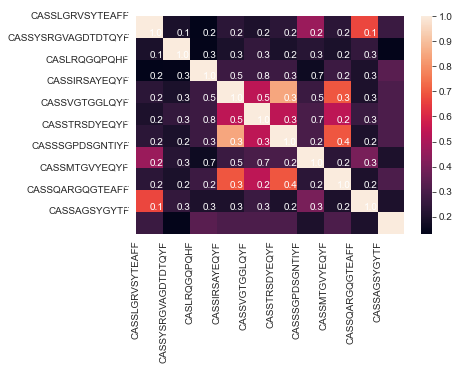

In [34]:
# visualize the matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cdr3_distance_score_matrix)
# add labels on the axes per sequence
plt.xticks(np.arange(len(df)), df['CDR3_beta'], rotation=90)
plt.yticks(np.arange(len(df)), df['CDR3_beta'], rotation=0)

for i in range(len(df)):
    for j in range(len(df)):
        plt.text(j, i, round(cdr3_distance_score_matrix[i][j], 1), ha="right", va="bottom", color="w")

plt.show()

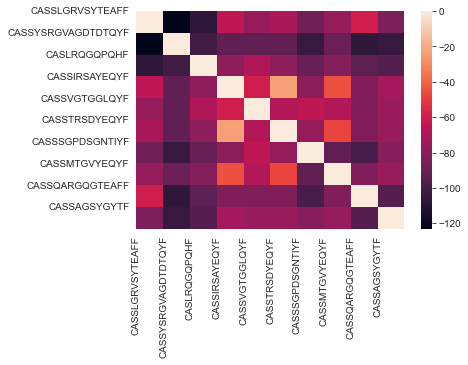

In [35]:
# visualize the matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(-tcrdist_score_matrix) # negation so higher is also better (like the plot above)
# add labels on the axes per sequence
plt.xticks(np.arange(len(df)), df['CDR3_beta'], rotation=90)
plt.yticks(np.arange(len(df)), df['CDR3_beta'], rotation=0)
plt.show()

In [37]:
from methodtools import lru_cache
from util import calculate_tcr_dist2_cached

def calculate_approx_distance(seq1, seq2, nan_distance=0):
    alpha_seq1 = seq1[0]
    alpha_seq2 = seq2[0]

    beta_seq1 = seq1[3]
    beta_seq2 = seq2[3]

    if distance_score(alpha_seq1, alpha_seq2) < 0.5 and distance_score(beta_seq1, beta_seq2) < 0.5:
        return np.infm

    return calculate_tcr_dist2_cached(seq1, seq2, nan_distance=nan_distance)


Predicting: 100%|██████████| 100/100 [13:32<00:00,  8.13s/it]


0.6175


Predicting: 100%|██████████| 100/100 [00:08<00:00, 11.45it/s]


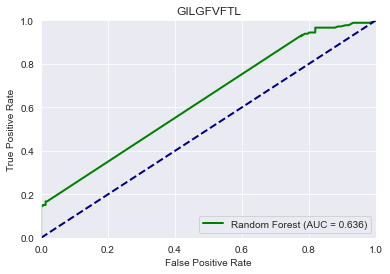

ROC AUC: 0.6360499507065396


In [39]:
from util import get_train_dataset, ProximityTreeClassifier, calculate_tcr_dist_multiple_chains
from sklearn.model_selection import train_test_split
from util import ProximityForestClassifier, calculate_tcr_dist2, calculate_tcr_dist2_cached
from sklearn.metrics import accuracy_score
from sklearn import metrics
from util import plot_roc_curve


x_columns = ['CDR3_alfa', 'TRAV', 'TRAJ', 'CDR3_beta', 'TRBV', 'TRBJ']
# x_columns = ['CDR3_alfa', 'CDR3_beta']
y_column = 'reaction'

df = get_train_dataset(vdjdb=True)
df = df[x_columns + [y_column]]
df = df.sample(2000) # (of the 12000)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# create numpy arrays for the train and test data
train_X = train_df[x_columns].to_numpy()
train_y = train_df[y_column].to_numpy()

val_X = val_df[x_columns].to_numpy()
val_y = val_df[y_column].to_numpy()


model = ProximityForestClassifier(reduce_features=False, distance_measure=calculate_approx_distance,
                                  distance_kwargs={"nan_distance": 0}, multithreaded=False)
model.fit(train_X, train_y)


predictions = model.predict(val_X)

print(accuracy_score(val_y, predictions))


predictions = model.predict_proba(val_X)
fpr, tpr, thresholds = metrics.roc_curve(val_y, predictions[:, 1], pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
plot_roc_curve(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.3f})', title="GILGFVFTL")
print(f"ROC AUC: {roc_auc}")

In [40]:
# get an idea of how many % of the sequences are ignored this way
df_small = df.sample(100)

COUNTER_SKIP = 0
COUNTER_TOTAL = 0
def calculate_approx_distance_ctr(seq1, seq2, nan_distance=0):
    global COUNTER_SKIP, COUNTER_TOTAL
    COUNTER_TOTAL += 1

    alpha_seq1 = seq1[0]
    alpha_seq2 = seq2[0]

    beta_seq1 = seq1[3]
    beta_seq2 = seq2[3]

    if distance_score(alpha_seq1, alpha_seq2) < 0.5 and distance_score(beta_seq1, beta_seq2) < 0.5:
        COUNTER_SKIP += 1
        return np.inf

    return calculate_tcr_dist2_cached(seq1, seq2, nan_distance=nan_distance)

In [43]:
train_df, val_df = train_test_split(df_small, test_size=0.2, random_state=42)

# create numpy arrays for the train and test data
train_X = train_df[x_columns].to_numpy()
train_y = train_df[y_column].to_numpy()

val_X = val_df[x_columns].to_numpy()
val_y = val_df[y_column].to_numpy()


model = ProximityForestClassifier(reduce_features=False, distance_measure=calculate_approx_distance_ctr,
                                  distance_kwargs={"nan_distance": 0}, multithreaded=False)

In [44]:
model.fit(train_X, train_y)
print(f"Skipped {COUNTER_SKIP} out of {COUNTER_TOTAL} sequences ({COUNTER_SKIP/COUNTER_TOTAL:.2%})")

Fitting: 100%|██████████| 100/100 [00:07<00:00, 13.44it/s]

Skipped 4386 out of 100581 sequences (4.36%)


In [45]:
COUNTER_SKIP = 0
COUNTER_TOTAL = 0
predictions = model.predict(val_X)
print(f"Skipped {COUNTER_SKIP} out of {COUNTER_TOTAL} sequences ({COUNTER_SKIP/COUNTER_TOTAL:.2%})")

Predicting: 100%|██████████| 100/100 [00:03<00:00, 31.81it/s]

Skipped 612 out of 2814 sequences (21.75%)


0.25


Predicting: 100%|██████████| 100/100 [00:00<00:00, 598.80it/s]


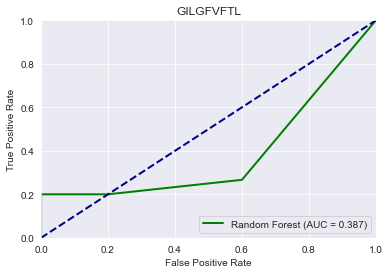

ROC AUC: 0.3866666666666667


In [46]:
print(accuracy_score(val_y, predictions))
predictions = model.predict_proba(val_X)
fpr, tpr, thresholds = metrics.roc_curve(val_y, predictions[:, 1], pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
plot_roc_curve(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.3f})', title="GILGFVFTL")
print(f"ROC AUC: {roc_auc}")